In [75]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import bootstrap_ensemble, interactive_plot_predictions, summarize_results, measure_smoothness_with_df, compute_rsquared
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

from postprocessing.arima import smooth_nn_predictions_with_arima_auto, smooth_nn_predictions_with_arima


TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [76]:
TRAIN_PROPORTION = 0.9
MODE = "diff" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [77]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [78]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_high_freq = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode=MODE,
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.001, 0.005, 0.01], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)


## Simple Prediction Model

Using mps device


100%|██████████| 100/100 [00:00<00:00, 115.27it/s]

Final training loss: 0.01411503367125988
Final validation loss: 0.49500030279159546
Final validation R^2: 0.341994984856945


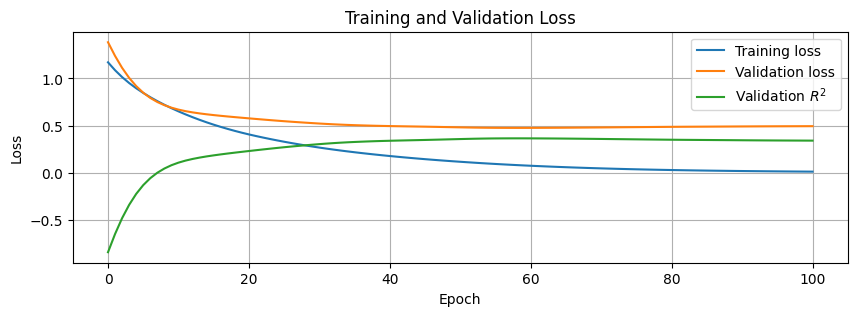

Best r squared: 0.36623771440346997 at epoch 58


In [79]:
model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=True,
                                                                       seed=SEED)

# Compute best r squared with epoch
best_r_squared = max(validation_r_squared)
best_epoch = validation_r_squared.index(best_r_squared)

print(f"Best r squared: {best_r_squared} at epoch {best_epoch}")

## High frequency predictions

In [80]:
# Predict for the high frequency data
device = get_device(False)
y_pred_high_freq = model(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
y_pred_high_freq_country = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq})

In [81]:
# Get the true GDPs
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid
all_true_gdps_country = np.concatenate([y_train, y_valid], axis=0)
all_dates = pd.concat([preprocessor.dates_train, preprocessor.dates_valid], axis=0)
all_true_gdps_country = pd.DataFrame({'date': all_dates, 'country': np.concatenate([country_train, country_valid], axis=0), 'y_true': np.concatenate([y_train, y_valid], axis=0)})

In [82]:
# Set the predicions to be plotted
predictions = y_pred_high_freq_country

# Add the true gdp for the points that we have
predictions = predictions.merge(all_true_gdps_country, on=["date", "country"], how="left")

# Remove duplicates
predictions = predictions.drop_duplicates(subset=["date", "country"])

# Rename y_pred to y_pred_high_freq
predictions = predictions.rename(columns={"y_pred": "y_pred_high_freq"})

In [83]:
# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions[predictions["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["y_true"].notna()
    y_trues = filtered_data["y_true"][non_nans]
    plt.figure(figsize=(15, 5))
    plt.plot(filtered_data["date"], filtered_data["y_pred_high_freq"], label="Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    #plt.fill_between(filtered_data["date"], filtered_data["y_pred_high_freq"] - 3 * filtered_data["stdv"], filtered_data["y_pred_high_freq"] + 3 * filtered_data["stdv"], alpha=0.2, color="blue")
    plt.title(f"High frequency predictions vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
countries.sort()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Japan', 'Korea', 'Switze…

<function __main__.plot_by_country(selected_country)>

In [84]:
# Compute the smoothness of the predictions
predictions2 = predictions.copy()
predictions2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
smoothness_results = measure_smoothness_with_df(predictions2)
print(f"Smoothness results: {smoothness_results}")

Smoothness results: [1.0237797498413486, 0.7024426028971791, 1.0772915670742904]


## Apply ARIMA smoothing

In [85]:
p = 1
d = 1
q = 1
adjusted_predictions = smooth_nn_predictions_with_arima(predictions, p, d, q)

In [86]:
def plot_by_country(selected_country):
    adjusted_filtered_data = adjusted_predictions[adjusted_predictions["country"] == selected_country]
    filtered_data = predictions[predictions["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["y_true"].notna()
    y_trues = filtered_data["y_true"][non_nans]
    plt.figure(figsize=(15, 5))
    plt.plot(filtered_data["date"], filtered_data["y_pred_high_freq"], label="Predicted", alpha=0.5)
    plt.plot(adjusted_filtered_data["date"], adjusted_filtered_data["y_pred_high_freq"], label="Adjusted Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    plt.title(f"High frequency predictions vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [87]:
# Plot the adjusted predictions
interact(plot_by_country, selected_country=dropdown)

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Japan', 'Korea', 'Switze…

<function __main__.plot_by_country(selected_country)>

In [88]:
# Compute the smoothness results
adjusted_predictions2 = adjusted_predictions.copy()
adjusted_predictions2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
smoothness_results_adjusted = measure_smoothness_with_df(adjusted_predictions2)
print(f"Smoothness results adjusted: {smoothness_results_adjusted}")

Smoothness results adjusted: [0.26596283639250146, 0.24680647147438234, 0.3639385802905219]


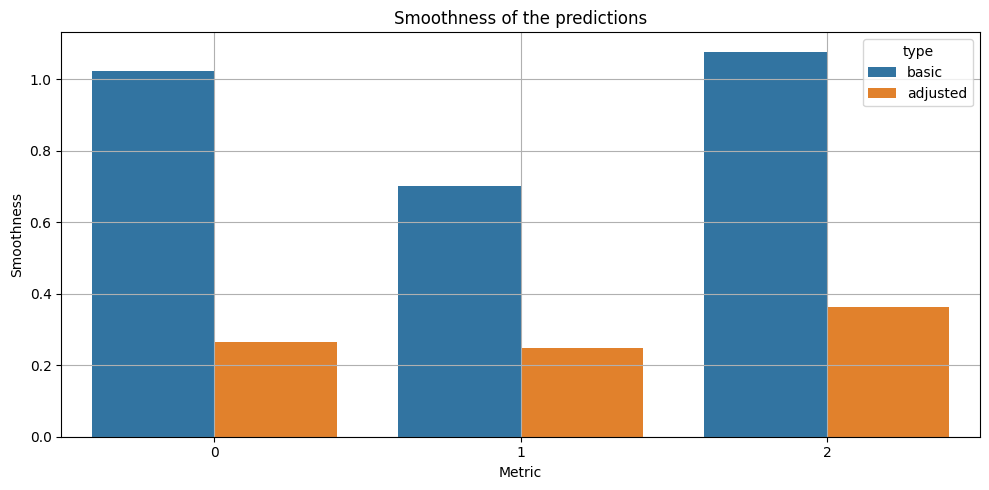

In [89]:
# Plot the results between the basic and adjusted predictions
all_smoothness_results = pd.DataFrame({'basic': smoothness_results, 'adjusted': smoothness_results_adjusted})

# I want one x per metric, not
all_smoothness_results = all_smoothness_results.reset_index().melt(id_vars='index', var_name='type', value_name='smoothness')

# Plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x='index', y='smoothness', hue='type', data=all_smoothness_results)
plt.title("Smoothness of the predictions")
plt.xlabel("Metric")
plt.ylabel("Smoothness")
plt.grid(True)
plt.tight_layout()
plt.show()

In [90]:
# Difference between the smoothness results
percentage_ratios = [smoothness_results[i] / smoothness_results_adjusted[i]   for i in range(len(smoothness_results))]
print(f"Smoothness ratios: {percentage_ratios}")

Smoothness ratios: [3.8493338532849735, 2.8461271647412625, 2.960091689686537]


## Create scatter plot data (Rsquared and Smoothness)


In [ ]:
# 1. We will create N_MODELS
# 2. We will train each model with a different seed
# 3. We will predict the high frequency data
# 4. Apply ARIMA for all combinaisons of parameters (p,d,q) from 0 to 3 (nb of models = 64)
# 5. For each combinaison, we will compute the medina smoothness / r squared on the validation data
# 6. Compute the median of r squared and smoothness for each combinaison

N_MODELS = 10
MAX_P = 10
MAX_D = 2
MAX_Q = 10
TOTAL_MODELS = MAX_P * MAX_D * MAX_Q
print(f"Total nb of combinaison: {TOTAL_MODELS}")

results = [] # map from config to a list of results (p, d, q) => [r_squared, smoothness]
for i in tqdm(range(N_MODELS)):

    X_train, y_train, X_valid, y_valid, x_high_freq = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                mode=MODE,
                                                                take_log_diff_gdp=True,
                                                                gt_trend_removal=False, 
                                                                keep_pca_components=180, 
                                                                noisy_data_stds=[0.001, 0.005, 0.01], 
                                                                add_encoded_month=False, 
                                                                gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

    model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=False,
                                                                       seed= SEED + i)

    y_pred_high_freq = model(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
    y_pred_high_freq_country = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq})
    
    for p in range(4):
        for d in range(4):
            for q in range(4):
                # Merge the predictions with the true GDPs
                predictions = y_pred_high_freq_country.copy()
                predictions = predictions.merge(all_true_gdps_country, on=['date', "country"], how='left')
                predictions = predictions.drop_duplicates(subset=['date', 'country'])
                predictions = predictions.rename(columns={"y_pred": "y_pred_high_freq"})

                # Apply ARIMA
                adjusted_predictions = smooth_nn_predictions_with_arima(predictions, p, d, q)

                # Compute the smoothness of the predictions
                adjusted_predictions2 = adjusted_predictions.copy()
                adjusted_predictions2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
                (m1,m2,m3) = measure_smoothness_with_df(adjusted_predictions2)

                # Compute the R squared
                valid_pred = adjusted_predictions[(adjusted_predictions["date"] >= preprocessor.splitting_date) & (adjusted_predictions["y_true"].notna())]
                valid_pred_y = valid_pred["y_pred_high_freq"]
                valid_true_y = valid_pred["y_true"]
                r_squared = compute_rsquared(valid_true_y, valid_pred_y)

                if i == 0:
                    results.append({'p': p, 'd': d, 'q': q, 'r_squared': [r_squared], 'smoothness': [m2]})
                else:
                    results[p * MAX_D * MAX_Q + d * MAX_Q + q]['r_squared'].append(r_squared)
                    results[p * MAX_D * MAX_Q + d * MAX_Q + q]['smoothness'].append(m2)

                print(f"Results: {results}")

Total nb of models: 200


  0%|          | 0/10 [00:00<?, ?it/s]

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)


/Users/leonardamsler/Desktop/EPFL/Master/MA1/Machine_Learning/ml-project-2-tpu_burners/utils/results.py:446: RuntimeWarning: divide by zero encountered in divide
  return [np.mean(smoothness_values), np.expm1(np.mean(np.log1p(smoothness_values))), (len(smoothness_values) / np.sum(1 / smoothness_values)) * 50]


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}]
Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}]
Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}]
Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'sm

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Chec

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible st

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible st

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible st

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregres

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible st

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregres

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332], 'smoothness': [1.666332427057372e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955], 'smoothness': [0.7347662939406422]}, {'p': 

/Users/leonardamsler/Desktop/EPFL/Master/MA1/Machine_Learning/ml-project-2-tpu_burners/utils/results.py:446: RuntimeWarning: divide by zero encountered in divide
  return [np.mean(smoothness_values), np.expm1(np.mean(np.log1p(smoothness_values))), (len(smoothness_values) / np.sum(1 / smoothness_values)) * 50]


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085], 'smoothness': [0.5292746074351455]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856], 'smoothness': [0.41369377471125585]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713], 'smoothness': [0.36598092296357815]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squared': [-0.5192893959013367], 'smoothness': [1.9900191134688405]}, {'p': 0, 'd': 2, 'q': 1, 'r_squared': [0.1650695186020955

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible st

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting 

Results: [{'p': 0, 'd': 0, 'q': 0, 'r_squared': [-0.2670453071897332, -0.29576320946221357], 'smoothness': [1.666332427057372e-33, 1.9925169248353595e-33]}, {'p': 0, 'd': 0, 'q': 1, 'r_squared': [0.10710829686020085, 0.05602516365838017], 'smoothness': [0.5292746074351455, 0.4899485378744588]}, {'p': 0, 'd': 0, 'q': 2, 'r_squared': [0.14554163366298856, 0.12615657226477373], 'smoothness': [0.41369377471125585, 0.4118931671424689]}, {'p': 0, 'd': 0, 'q': 3, 'r_squared': [0.23317532851650713, 0.22326607911977614], 'smoothness': [0.36598092296357815, 0.3282955063004462]}, {'p': 0, 'd': 1, 'q': 0, 'r_squared': [0.1682175264665362], 'smoothness': [0.7036531490505793]}, {'p': 0, 'd': 1, 'q': 1, 'r_squared': [0.2301892771690195], 'smoothness': [0.2538777126628785]}, {'p': 0, 'd': 1, 'q': 2, 'r_squared': [0.23409314719140917], 'smoothness': [0.24561128148684594]}, {'p': 0, 'd': 1, 'q': 3, 'r_squared': [0.26435203332213053], 'smoothness': [0.29711634343974014]}, {'p': 0, 'd': 2, 'q': 0, 'r_squa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


IndexError: list index out of range

In [93]:
# Compute the median of the r squared and smoothness
final_results = []
for result in results:
    p = result['p']
    d = result['d']
    q = result['q']
    r_squared = np.median(result['r_squared'])
    smoothness = np.median(result['smoothness'])
    final_results.append({'p': p, 'd': d, 'q': q, 'r_squared': r_squared, 'smoothness': smoothness})
    

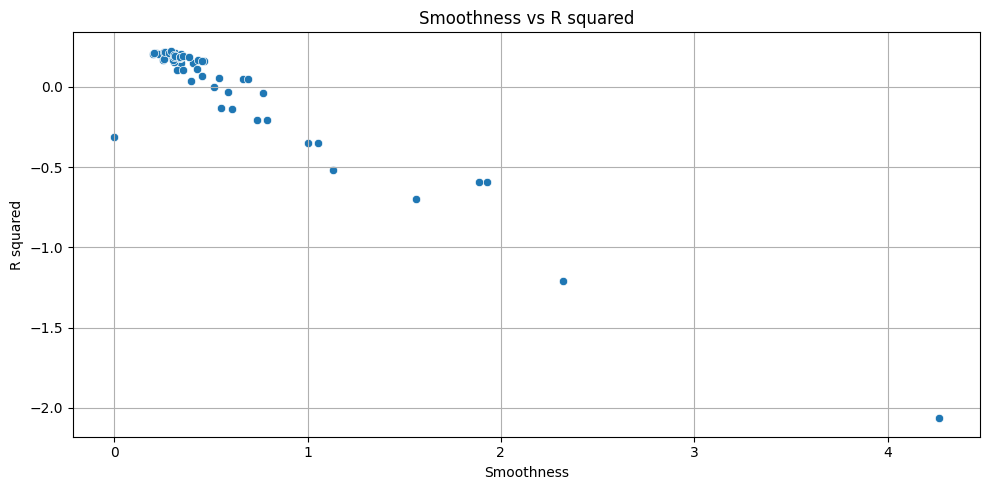

In [95]:
# Plot the results
final_results_df = pd.DataFrame(final_results)
final_results_df['r_squared'] = final_results_df['r_squared'].astype(float)
final_results_df['smoothness'] = final_results_df['smoothness'].astype(float)

# I want the smoothness in x and the r squared in y

plt.figure(figsize=(10, 5))
sns.scatterplot(x='smoothness', y='r_squared', data=final_results_df)
plt.title("Smoothness vs R squared")
plt.xlabel("Smoothness")
plt.ylabel("R squared")
plt.grid(True)
plt.tight_layout()
plt.show()


In [100]:
# Best combinaison of parameters for R squared
best_r_squared = final_results_df.loc[final_results_df['r_squared'].idxmax()]
print(f"Best combinaison of parameters for R squared: {best_r_squared}")

Best combinaison of parameters for R squared: p             3.000000
d             0.000000
q             2.000000
r_squared     0.225402
smoothness    0.291773
Name: 50, dtype: float64
